# Introduction

**As I have recently become interested in data analysis and I like to watch anime, it occurred to me to make an analysis of the top 2000 anime as well as some kind of recommendation system.Given that this is one of my first projects, I am aware that many things can probably be done in a much better way and that the recommendation system is very basic when we take into account the data it takes into consideration, as well as the computer power I have for training.**

### Importing libraries we gonna use

In [1]:
import numpy as np
import pandas as pd 
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,sigmoid_kernel
import seaborn as sns # visualization
import matplotlib.pyplot as plt #visualization

### Importing the data

In [2]:
anime_data = pd.read_csv('MALTop2000.csv')
anime_data.head()

,Unnamed: 0,Name,Type,Score,Score Rank,Popularity Rank,Air Date,Studio,Num. of episodes,Genres,Theme(s),Demographic
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,"Apr 5, 2009 to Jul 4, 2010",['Bones'],64,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],Shounen
1,1,Spy x Family,TV,9.09,2,350,"Apr 9, 2022 to ?","['Wit Studio', ' CloverWorks']",12,"['Action', 'Comedy']",['Childcare'],Shounen
2,2,Shingeki no Kyojin Season 3 Part 2,TV,9.08,3,32,"Apr 29, 2019 to Jul 1, 2019",['Wit Studio'],10,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",Shounen
3,3,Steins;Gate,TV,9.08,4,13,"Apr 6, 2011 to Sep 14, 2011",['White Fox'],24,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",None
4,4,Gintama°,TV,9.08,5,335,"Apr 8, 2015 to Mar 30, 2016",['Bandai Namco Pictures'],51,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen


In [3]:
anime_data.columns = anime_data.columns.str.replace('Unnamed: 0', 'index')

In [4]:
anime_data.columns

Index(['index', 'Name', 'Type', 'Score', 'Score Rank', 'Popularity Rank',
       'Air Date', 'Studio', 'Num. of episodes', 'Genres', 'Theme(s)',
       'Demographic'],
      dtype='object')

In [5]:
anime_data1 = anime_data.copy()

In [6]:
anime_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             2000 non-null   int64  
 1   Name              2000 non-null   object 
 2   Type              2000 non-null   object 
 3   Score             2000 non-null   float64
 4   Score Rank        2000 non-null   int64  
 5   Popularity Rank   2000 non-null   int64  
 6   Air Date          2000 non-null   object 
 7   Studio            2000 non-null   object 
 8   Num. of episodes  2000 non-null   int64  
 9   Genres            2000 non-null   object 
 10  Theme(s)          2000 non-null   object 
 11  Demographic       2000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 187.6+ KB


### Preprocessing data

As we can see, we are lucky that we do not have null values ​​in our dataset. The only change we will make is to divide Air Date into Start Date and End Date columns.

In [7]:
#Divide the Air Date column into Start Date and End Date columns
air_date_split = anime_data['Air Date'].str.split(" to ")
anime_data["Start Date"] = air_date_split.apply(lambda x : x[0])
anime_data["End Date"] = air_date_split.apply(lambda x : x[1] if len(x) > 1 else None)
#Drop the Air Date column
anime_data.drop("Air Date", axis=1, inplace = True)
#Transform 'Start Date' into date column
anime_data["Start Date"] = pd.to_datetime(anime_data["Start Date"])
#Add year column
anime_data["Year"] = anime_data["Start Date"].dt.year
#See the results
anime_data.head()

,index,Name,Type,Score,Score Rank,Popularity Rank,Studio,Num. of episodes,Genres,Theme(s),Demographic,Start Date,End Date,Year
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
1,1,Spy x Family,TV,9.09,2,350,"['Wit Studio', ' CloverWorks']",12,"['Action', 'Comedy']",['Childcare'],Shounen,2022-04-09,?,2022
2,2,Shingeki no Kyojin Season 3 Part 2,TV,9.08,3,32,['Wit Studio'],10,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",Shounen,2019-04-29,"Jul 1, 2019",2019
3,3,Steins;Gate,TV,9.08,4,13,['White Fox'],24,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",None,2011-04-06,"Sep 14, 2011",2011
4,4,Gintama°,TV,9.08,5,335,['Bandai Namco Pictures'],51,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,2015-04-08,"Mar 30, 2016",2015


In [8]:
#Categorize Type and Demographic columns
anime_data["Type"] = anime_data["Type"].astype("category")
anime_data["Demographic"] = anime_data["Demographic"].astype("category")
#See the results
anime_data[["Type", "Demographic"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Type         2000 non-null   category
 1   Demographic  2000 non-null   category
dtypes: category(2)
memory usage: 4.5 KB


### Analyzing data

**Top 10 animes with the best rating**

In [9]:
top10score = anime_data.sort_values("Score Rank").head(10)
top10score

,index,Name,Type,Score,Score Rank,Popularity Rank,Studio,Num. of episodes,Genres,Theme(s),Demographic,Start Date,End Date,Year
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
1,1,Spy x Family,TV,9.09,2,350,"['Wit Studio', ' CloverWorks']",12,"['Action', 'Comedy']",['Childcare'],Shounen,2022-04-09,?,2022
2,2,Shingeki no Kyojin Season 3 Part 2,TV,9.08,3,32,['Wit Studio'],10,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",Shounen,2019-04-29,"Jul 1, 2019",2019
3,3,Steins;Gate,TV,9.08,4,13,['White Fox'],24,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",None,2011-04-06,"Sep 14, 2011",2011
4,4,Gintama°,TV,9.08,5,335,['Bandai Namco Pictures'],51,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,2015-04-08,"Mar 30, 2016",2015
5,5,Gintama',TV,9.05,6,385,['Sunrise'],51,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,2011-04-04,"Mar 26, 2012",2011
6,6,Gintama: The Final,Movie,9.05,7,1746,['Bandai Namco Pictures'],1,"['Action', 'Comedy', 'Drama', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,2021-01-08,None,2021
7,7,Hunter x Hunter (2011),TV,9.05,8,10,['Madhouse'],148,"['Action', 'Adventure', 'Fantasy']",['None'],Shounen,2011-10-02,"Sep 24, 2014",2011
8,8,Fruits Basket: The Final,TV,9.04,9,551,['TMS Entertainment'],13,"['Drama', 'Romance', 'Slice of Life', 'Superna...",['None'],Shoujo,2021-04-06,"Jun 29, 2021",2021
9,9,Gintama': Enchousen,TV,9.04,10,695,['Sunrise'],13,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,2012-10-04,"Mar 28, 2013",2012


#### Top 10 anime by popularity

In [10]:
top10pop = anime_data.sort_values("Popularity Rank").head(10)
top10pop

,index,Name,Type,Score,Score Rank,Popularity Rank,Studio,Num. of episodes,Genres,Theme(s),Demographic,Start Date,End Date,Year
102,102,Shingeki no Kyojin,TV,8.53,103,1,['Wit Studio'],25,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",Shounen,2013-04-07,"Sep 29, 2013",2013
69,69,Death Note,TV,8.63,70,2,['Madhouse'],37,"['Supernatural', 'Suspense']",['Psychological'],Shounen,2006-10-04,"Jun 27, 2007",2006
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
113,113,One Punch Man,TV,8.51,114,4,['Madhouse'],12,"['Action', 'Comedy']","['Parody', 'Super Power']",Seinen,2015-10-05,"Dec 21, 2015",2015
628,628,Boku no Hero Academia,TV,7.95,629,6,['Bones'],13,['Action'],"['School', 'Super Power']",Shounen,2016-04-03,"Jun 26, 2016",2016
878,878,Tokyo Ghoul,TV,7.80,879,7,['Studio Pierrot'],12,"['Action', 'Fantasy', 'Horror']","['Gore', 'Psychological']",Seinen,2014-07-04,"Sep 19, 2014",2014
604,604,Naruto,TV,7.97,605,8,['Studio Pierrot'],220,"['Action', 'Adventure', 'Fantasy']",['Martial Arts'],Shounen,2002-10-03,"Feb 8, 2007",2002
89,89,Kimetsu no Yaiba,TV,8.55,90,9,['ufotable'],26,"['Action', 'Fantasy']",['Historical'],Shounen,2019-04-06,"Sep 28, 2019",2019
7,7,Hunter x Hunter (2011),TV,9.05,8,10,['Madhouse'],148,"['Action', 'Adventure', 'Fantasy']",['None'],Shounen,2011-10-02,"Sep 24, 2014",2011
24,24,Kimi no Na wa.,Movie,8.87,25,11,['CoMix Wave Films'],1,"['Drama', 'Supernatural']",['Romantic Subtext'],None,2016-08-26,None,2016


#### Plot of Total Animes by type

Text(0.5, 1.0, 'Total Animes by Type')

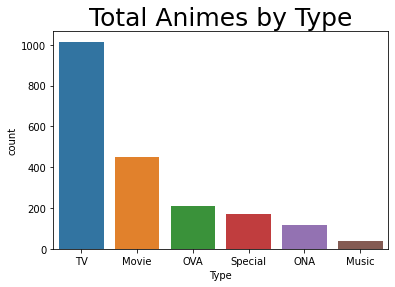

In [11]:
ordered_cats = np.asarray(anime_data.Type.value_counts().index)
plt.rcParams["figure.figsize"] = (12,6)
ax = sns.countplot(x="Type", data=anime_data, order=ordered_cats)
ax.set_title("Total Animes by Type", fontsize=25)

**As expected, most of them are TV shows, then movies, and then various specials**

Text(0.5, 1.0, 'Total Anime by Year')

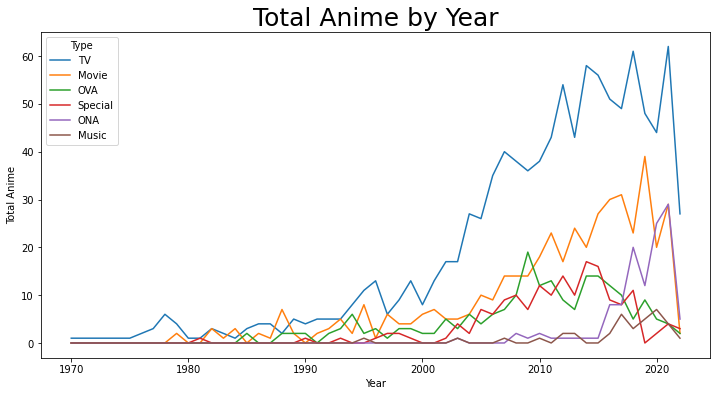

In [12]:
#Lineplot of Series by year
animes_by_year = anime_data.groupby(["Type", "Year"], as_index=False).size()
plt.rcParams["figure.figsize"] = (12,6)
ax = sns.lineplot(x="Year", y="size", data=animes_by_year, hue="Type",
                  hue_order=["TV", "Movie", "OVA", "Special", "ONA", "Music"])
sns.move_legend(ax, "upper left")
ax.set_ylabel("Total Anime")
ax.set_title("Total Anime by Year", fontsize=25)

**From the plot, we can see that in the beginning they mostly made TV shows, as well as how growing popularity of anime around the world contributed to the release of a larger number of anime, which grows every year.**

**Plot of Total Animes by Demographic**

Text(0.5, 1.0, 'Total Animes by Demographic')

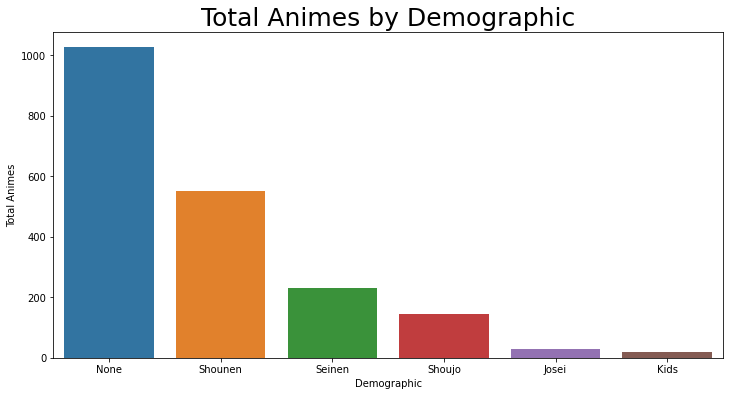

In [13]:
animes_by_demo = anime_data.groupby("Demographic", as_index=False, observed=True).size()
ordered_cats = animes_by_demo.sort_values("size", ascending=False)["Demographic"]
plt.rcParams["figure.figsize"] = (12,6)
ax = sns.barplot(x="Demographic", y="size", data=animes_by_demo, order=ordered_cats)
ax.set_ylabel("Total Animes")
ax.set_title("Total Animes by Demographic", fontsize=25)

**Here we notice the first drawback of our dataset, as 50% of the dataset has None value for demographics.**





**As our genres are written in a string, we first need to convert them into a list, and later we will use the <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html" target="_blank">explode</a> functionality from pandas to separate them into several rows so that we can more easily conclude how frequent each genre is.**

In [14]:
def str_values_to_list(str_values):
    
 
    str_values = str_values.strip("[]").replace("'", "")
    list_values = str_values.split(", ")
    
    return list_values

In [15]:
anime_data["Genres"] = anime_data["Genres"].apply(str_values_to_list)

In [16]:
anime_data_genre_exp = anime_data.explode("Genres")
#Convert to category
anime_data_genre_exp["Genres"] = anime_data_genre_exp["Genres"].astype("category")
#See the results
anime_data_genre_exp.head()

,index,Name,Type,Score,Score Rank,Popularity Rank,Studio,Num. of episodes,Genres,Theme(s),Demographic,Start Date,End Date,Year
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,Action,['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,Adventure,['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,Drama,['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,['Bones'],64,Fantasy,['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
1,1,Spy x Family,TV,9.09,2,350,"['Wit Studio', ' CloverWorks']",12,Action,['Childcare'],Shounen,2022-04-09,?,2022


Text(0.5, 1.0, 'Total Animes by Genres')

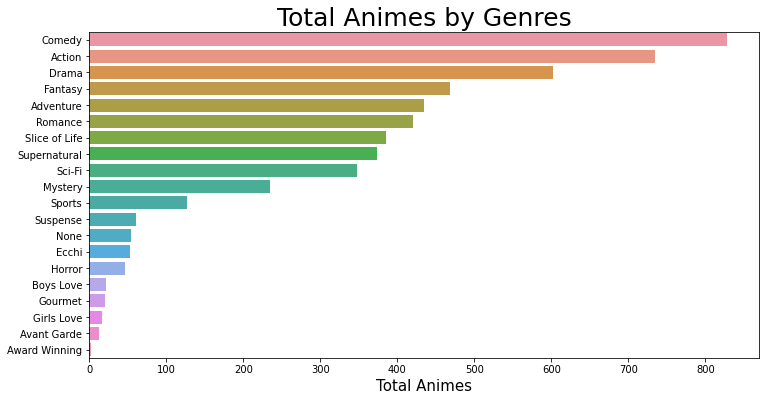

In [17]:
animes_by_genre = anime_data_genre_exp.groupby("Genres").size().sort_values(ascending=False).reset_index()
plt.rcParams["figure.figsize"] = (12, 6)
ax = sns.barplot(y="Genres", x=0, data=animes_by_genre, order=animes_by_genre.Genres)
ax.set_xlabel("Total Animes", fontsize=15)
ax.set_ylabel("")
ax.set_title("Total Animes by Genres", fontsize=25)

**We can notice that comedy is the most represented along with action and drama. We also see the incompleteness of our dataset again, as None appears again.**

**The same thing we did with genres, we will do with studios as sometimes several studios work on one anime**

In [18]:
anime_data["Studio"] = anime_data["Studio"].apply(str_values_to_list)
anime_data_studio_exp = anime_data.explode("Studio")
anime_data_studio_exp["Studio"] = anime_data_studio_exp["Studio"].apply(str.strip)
#See the results
anime_data_studio_exp.head()

,index,Name,Type,Score,Score Rank,Popularity Rank,Studio,Num. of episodes,Genres,Theme(s),Demographic,Start Date,End Date,Year
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,Bones,64,"[Action, Adventure, Drama, Fantasy]",['Military'],Shounen,2009-04-05,"Jul 4, 2010",2009
1,1,Spy x Family,TV,9.09,2,350,Wit Studio,12,"[Action, Comedy]",['Childcare'],Shounen,2022-04-09,?,2022
1,1,Spy x Family,TV,9.09,2,350,CloverWorks,12,"[Action, Comedy]",['Childcare'],Shounen,2022-04-09,?,2022
2,2,Shingeki no Kyojin Season 3 Part 2,TV,9.08,3,32,Wit Studio,10,"[Action, Drama]","['Gore', 'Military', 'Survival']",Shounen,2019-04-29,"Jul 1, 2019",2019
3,3,Steins;Gate,TV,9.08,4,13,White Fox,24,"[Drama, Sci-Fi, Suspense]","['Psychological', 'Time Travel']",None,2011-04-06,"Sep 14, 2011",2011


In [19]:
#Total animes by studio
animes_by_studio = anime_data_studio_exp.groupby("Studio").size().sort_values(ascending=False).reset_index()
animes_by_studio.columns = ["Studio", "Animes"]
#Average scores by studio
scores_by_studio =anime_data_studio_exp.groupby("Studio").Score.mean().sort_values(ascending=False).reset_index()
scores_by_studio.columns = ["Studio", "Avg_score"]
#Merge 2 dataframes on column "Studio"
studios = animes_by_studio.merge(scores_by_studio, left_on="Studio", right_on="Studio")
#Drop Animes with Studio="None"
studios.drop(studios[studios["Studio"] == "None"].index, axis=0, inplace=True)
#See the results
studios.head()

,Studio,Animes,Avg_score
0,Production I.G,117,7.862650
1,Sunrise,112,7.835714
2,Toei Animation,106,7.720283
3,Madhouse,99,7.981111
4,Studio Deen,82,7.731707


**We grouped anime by studio and calculated the average rating of anime when the studio is involved in its production. We also removed None from our studio dataframe.**

Text(0.5, 1.0, 'Animes released and Average Score by Studio')

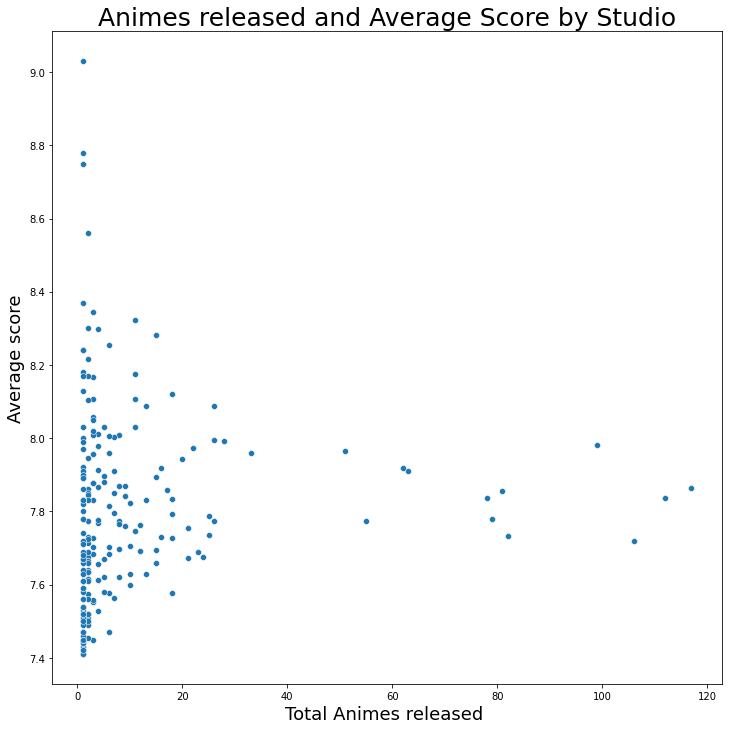

In [20]:
#Scatterplot of Animes vs Avg_score
plt.rcParams["figure.figsize"] = (12, 12)
ax = sns.scatterplot(x="Animes", y="Avg_score", data=studios)
ax.set_xlabel("Total Animes released ", fontsize=18)
ax.set_ylabel("Average score", fontsize=18)
ax.set_title("Animes released and Average Score by Studio", fontsize=25)

Text(0.5, 0.98, 'Top 20 popular Studios and Top 20 Average Scores')

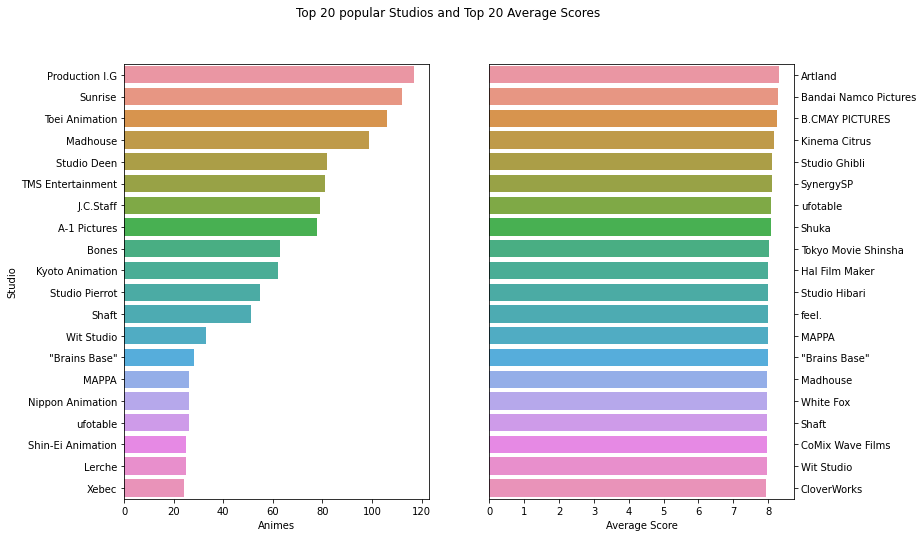

In [21]:
#Filter for studios with more than 5 animes
valid_studios = studios[studios["Animes"] > 5]
#Plot both graphs
fig, axes = plt.subplots(1, 2, figsize=(12,8))
ax0 = sns.barplot(y="Studio", x="Animes",
                  data=valid_studios.sort_values("Animes", ascending=False)[:20], ax=axes[0])
ax1 = sns.barplot(y="Studio", x="Avg_score",
                  data=valid_studios.sort_values("Avg_score", ascending=False)[:20], ax=axes[1])
ax1.set_xlabel("Average Score")
#Stick Y label ticks to right for readibilty
ax1.set_ylabel("")
ax1.yaxis.tick_right()
#Title
fig.suptitle("Top 20 popular Studios and Top 20 Average Scores")

**Here we can see how many studios, when they make a large number of anime, lose quality and get lower ratings. One of the exceptions is Madhouse, which despite having almost 100 anime still has a very good average rating.**

### Recommendation System

**Our recommendation system will be very basic, as we are limited both with data and hardware, and we cannot create a system like that of large companies like Netflix. But even so, the results will be very good in the end, they even surprised me a little.**

**The algorithm we will use to calculate the similarity is <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html" target="_blank">cosine similarity</a>.Cosine similarity is a popular choice for computing the similarity of documents represented as <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" target="_blank">tf-idf vectors</a>.
First, we will combine the features that we want to take into consideration (in our case Genres,Studio,Score,Popularity Rank,Themes,Demographic and Type) into one string, and then with the help of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer" target="_blank">TfidfTransformer</a> we will transfer that string to tf-idf representation so that we can use cosine similarity.**

We will use a copy of the dataset from the beginning, as we changed the dataset in one part, so if we tried to return the type from category to object, we lose a lot of value


In [22]:
anime_data1.head()

,index,Name,Type,Score,Score Rank,Popularity Rank,Air Date,Studio,Num. of episodes,Genres,Theme(s),Demographic
0,0,Fullmetal Alchemist: Brotherhood,TV,9.14,1,3,"Apr 5, 2009 to Jul 4, 2010",['Bones'],64,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],Shounen
1,1,Spy x Family,TV,9.09,2,350,"Apr 9, 2022 to ?","['Wit Studio', ' CloverWorks']",12,"['Action', 'Comedy']",['Childcare'],Shounen
2,2,Shingeki no Kyojin Season 3 Part 2,TV,9.08,3,32,"Apr 29, 2019 to Jul 1, 2019",['Wit Studio'],10,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",Shounen
3,3,Steins;Gate,TV,9.08,4,13,"Apr 6, 2011 to Sep 14, 2011",['White Fox'],24,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",None
4,4,Gintama°,TV,9.08,5,335,"Apr 8, 2015 to Mar 30, 2016",['Bandai Namco Pictures'],51,"['Action', 'Comedy', 'Sci-Fi']","['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen


In [23]:
anime_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             2000 non-null   int64  
 1   Name              2000 non-null   object 
 2   Type              2000 non-null   object 
 3   Score             2000 non-null   float64
 4   Score Rank        2000 non-null   int64  
 5   Popularity Rank   2000 non-null   int64  
 6   Air Date          2000 non-null   object 
 7   Studio            2000 non-null   object 
 8   Num. of episodes  2000 non-null   int64  
 9   Genres            2000 non-null   object 
 10  Theme(s)          2000 non-null   object 
 11  Demographic       2000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 187.6+ KB


In [24]:
anime_data1['Genres'] = anime_data1['Genres'].apply(lambda x: x[1:-1])
anime_data1['Genres']

0       'Action', 'Adventure', 'Drama', 'Fantasy'
1                              'Action', 'Comedy'
2                               'Action', 'Drama'
3                   'Drama', 'Sci-Fi', 'Suspense'
4                    'Action', 'Comedy', 'Sci-Fi'
                          ...                    
1995                                     'Comedy'
1996                           'Comedy', 'Sci-Fi'
1997                           'Action', 'Comedy'
1998                    'Comedy', 'Slice of Life'
1999                'Action', 'Comedy', 'Mystery'
Name: Genres, Length: 2000, dtype: object

In [25]:
anime_data1['Studio'] = anime_data1['Studio'].apply(lambda x: x[1:-1])
anime_data1['Studio']

0                                       'Bones'
1       'Wit Studio', '            CloverWorks'
2                                  'Wit Studio'
3                                   'White Fox'
4                       'Bandai Namco Pictures'
                         ...                   
1995                                'Satelight'
1996                                'White Fox'
1997                              'Studio Deen'
1998                             'SILVER LINK.'
1999                                  'Sunrise'
Name: Studio, Length: 2000, dtype: object

In [26]:
anime_data1['Theme(s)'] = anime_data1['Theme(s)'].apply(lambda x: x[1:-1])
anime_data1['Theme(s)']

0                                           'Military'
1                                          'Childcare'
2                       'Gore', 'Military', 'Survival'
3                       'Psychological', 'Time Travel'
4       'Gag Humor', 'Historical', 'Parody', 'Samurai'
                             ...                      
1995                          'Mahou Shoujo', 'School'
1996                                            'None'
1997                          'Detective', 'Workplace'
1998                             'Iyashikei', 'School'
1999                       'Adult Cast', 'Super Power'
Name: Theme(s), Length: 2000, dtype: object

In [27]:
anime_features = ['Genres','Studio','Score','Popularity Rank','Theme(s)','Demographic', 'Type']

In [28]:
for feature in anime_features:
    anime_data1[feature] = anime_data1[feature].fillna('')

In [29]:
anime_combined = anime_data1['Genres'] + ' ' +  anime_data1['Theme(s)'] + ' ' + anime_data1['Demographic'] + ' ' +  anime_data1['Studio']+ ' ' + anime_data1['Type']+  ' ' + str(anime_data1['Score'])+ ' ' +str(anime_data1['Popularity Rank'])

In [30]:
vectorizer = TfidfVectorizer()

In [31]:
feature_vectors = vectorizer.fit_transform(anime_combined)

In [32]:
similarity = cosine_similarity(feature_vectors)

**Our system will ask us the name of the anime for which we want to find out which other anime are similar to it. Anima must be in the top 2000 data set. Let's see, for example, which anime are similar to Black Lagoon**

In [38]:
anime_name = input('Enter your favourite anime name : ')

list_of_all_titles =anime_data1['Name'].tolist()

#difflib will help us, no matter how we write (lowercase, uppercase,some letters are missing etc.), it will take the one that is most similar to us from the dataset
find_close_match = difflib.get_close_matches(anime_name, list_of_all_titles)

close_match = find_close_match[0]

index_of_the_anime = anime_data1[anime_data1.Name == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[index_of_the_anime]))

sorted_similar_animes = sorted(similarity_score, key = lambda x : x[1], reverse = True)

print('Anime sugested for you : \n')

i = 1
for anime in sorted_similar_animes:
    index = anime[0]
    title_from_id = anime_data1.loc[anime_data1['index'] == index].values[0][1]
    if(i < 30):
        print(i, '.',title_from_id)
        i += 1

Enter your favourite anime name :  Black Lagoon


Anime sugested for you : 

1 . Black Lagoon: The Second Barrage
2 . Black Lagoon
3 . Black Lagoon: Roberta's Blood Trail
4 . Gungrave
5 . Gokushufudou Part 2
6 . Jormungand: Perfect Order
7 . Jormungand
8 . 91 Days
9 . JoJo no Kimyou na Bouken Part 5: Ougon no Kaze
10 . Trigun
11 . Hinamatsuri (TV)
12 . Katekyo Hitman Reborn!
13 . Monster
14 . Master Keaton
15 . Trigun: Badlands Rumble
16 . Baccano!
17 . Touhai Densetsu Akagi: Yami ni Maiorita Tensai
18 . Gokusen
19 . Phantom: Requiem for the Phantom
20 . Master Keaton OVA
21 . Redline
22 . Seto no Hanayome
23 . Baccano! Specials
24 . Toshokan Sensou
25 . Hunter x Hunter (2011)
26 . One Outs
27 . Nejimaki Seirei Senki: Tenkyou no Alderamin
28 . Toshokan Sensou: Kakumei no Tsubasa
29 . Cowboy Bebop


**Let's look at some of the anime that the system recommended**

In [39]:
anime_data1[anime_data1['Name'].isin(['Black Lagoon','Gungrave','Trigun','Phantom: Requiem for the Phantom','Baccano!'])]

,index,Name,Type,Score,Score Rank,Popularity Rank,Air Date,Studio,Num. of episodes,Genres,Theme(s),Demographic
175,175,Baccano!,TV,8.38,176,160,"Jul 27, 2007 to Nov 2, 2007","""Brain's Base""",13,"'Action', 'Comedy', 'Mystery', 'Supernatural'","'Historical', 'Organized Crime'",None
303,303,Trigun,TV,8.22,304,240,"Apr 1, 1998 to Sep 30, 1998",'Madhouse',26,"'Action', 'Adventure', 'Comedy', 'Drama', 'Sci...",'Adult Cast',Shounen
519,519,Black Lagoon,TV,8.03,520,147,"Apr 9, 2006 to Jun 25, 2006",'Madhouse',12,'Action',"'Adult Cast', 'Organized Crime'",Seinen
608,608,Phantom: Requiem for the Phantom,TV,7.97,609,612,"Apr 3, 2009 to Sep 25, 2009",'Bee Train',26,"'Action', 'Drama', 'Suspense'",'Organized Crime',Seinen
816,816,Gungrave,TV,7.84,817,1107,"Oct 7, 2003 to Mar 30, 2004",'Madhouse',26,"'Action', 'Drama', 'Sci-Fi'","'Adult Cast', 'Gore', 'Organized Crime', 'Supe...",Seinen


**As we can see, the anime that we received as suggestions are similar in terms of studio, genre and theme, so we can conclude that the system gives us similar recommendations.**

## Conclusion

**That would be some basic analysis and recommendation system. As I said at the beginning, I am still a beginner and I believe that some things could have been done in a better way, but the whole project was very interesting and I learned a lot from the side. I hope that maybe someone who sees this project will get a good idea how to get started with recommendation systems and help in the realization of one of their projects**